# Generating DAG's on Wikipedia articles with Langchain

## Introduction
Yesterday I was bored, and I've already done some work generating protein association networks with Cytoscape and String.
I was wondering if this could be extended to other domains with the use of LLM's to generate JSON graph data.
I tried it with an paragraph in an article about the [Muslim Brotherhood](https://en.wikipedia.org/wiki/Muslim_Brotherhood) since I had to write a final paper on that for my first year seminar at UCLA and it yielded somewhat interesting results.
I was able to import the JSON into Cytoscape and do an analysis, but I want to try investigating the feasibility of doing this on a larger scale.


## Load Wikipedia article
We'll use Langchain's loaders to scrape Wikipedia articles.
This way, we can programmatically get Wikipedia articles and chunk them later.

In [2]:
from langchain_community.document_loaders import WikipediaLoader

In [3]:
docs = WikipediaLoader(query="Syrian Civil War", load_max_docs=1).load()
docs[0]

Document(metadata={'title': 'Syrian civil war', 'summary': "The Syrian civil war began with the Syrian revolution in March 2011, when popular discontent with the Ba'athist regime ruled by Bashar al-Assad triggered large-scale protests and pro-democracy rallies across Syria, as part of the wider Arab Spring. The Assad regime responded to the protests with lethal force, sparking a civil war. The Syrian revolution lasted almost 14 years and culminated in the fall of the Assad regime in December 2024. Many sources regard this as the end of the civil war. \nThe Syrian opposition to Bashar al-Assad began an insurgency, forming groups such as the Free Syrian Army. Anti-Assad forces received arms from states such as Qatar and Turkey. Pro-Assad forces received financial and military support from Iran and Russia: Iran launched a military intervention in support of the Syrian government in 2013, and Russia followed in 2015. By this time, rebels had established the Syrian Interim Government after 

In [4]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

article_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1200,
    chunk_overlap = 200
)

split_article = article_splitter.split_documents(docs)

## Defining the schema

For our DAG, we need to define schemas for nodes and edges. Nodes have to be event centric, but minimal, and edges have to be causal with evidence.

In [5]:
# Minimal schemas for a temporal causal graph (Cytoscape-ready)

from enum import Enum
from typing import List, Optional, Dict, Any, Tuple, Literal
from pydantic import BaseModel, Field, constr, confloat
from datetime import date


# --- Enums ---

class NodeType(str, Enum):
    Event = "Event"
    Person = "Person"
    Organization = "Organization"
    Place = "Place"
    Concept = "Concept"


class RelationType(str, Enum):
    causes = "causes"
    leads_to = "leads_to"
    enables = "enables"
    triggers = "triggers"
    prevents = "prevents"
    mitigates = "mitigates"


Polarity = Literal[1, -1]  # +1 promotes/enables; -1 inhibits/prevents


# --- Evidence & Provenance (minimal) ---

class Evidence(BaseModel):
    quote: constr(strip_whitespace=True, min_length=1)
    citation_ids: List[str] = Field(default_factory=list)
    section: Optional[str] = None
    char_spans: Optional[Tuple[int, int]] = None


class Provenance(BaseModel):
    article_id: Optional[str] = None
    revision_id: Optional[str] = None
    run_id: Optional[str] = None


# --- Core graph models ---

class EventNode(BaseModel):
    id: constr(strip_whitespace=True, min_length=1)
    label: constr(strip_whitespace=True, min_length=1)
    type: NodeType = NodeType.Event
    time_start: Optional[date] = None
    time_end: Optional[date] = None
    wikidata_id: Optional[str] = None
    provenance: Optional[Provenance] = None
    meta: Dict[str, Any] = Field(default_factory=dict)


class CausalEdge(BaseModel):
    id: constr(strip_whitespace=True, min_length=1)
    source: constr(strip_whitespace=True, min_length=1)
    target: constr(strip_whitespace=True, min_length=1)
    relation_type: RelationType
    polarity: Polarity = 1
    confidence: confloat(ge=0.0, le=1.0) = 0.5
    lag_days: Optional[int] = None
    evidence: List[Evidence] = Field(default_factory=list)
    temporal_valid: bool = True
    provisional: bool = False
    meta: Dict[str, Any] = Field(default_factory=dict)


# --- Cytoscape export wrappers (minimal) ---

class CyNode(BaseModel):
    data: EventNode


class CyEdge(BaseModel):
    data: CausalEdge


class CyElements(BaseModel):
    nodes: List[CyNode] = Field(default_factory=list)
    edges: List[CyEdge] = Field(default_factory=list)


## Creating extractor
Using the schemas defined above, we're going to build an extraction chain with Gemini. It'll take our document and parse it into CyElements, which can be imported into Cytoscape later.

In [ ]:
from langchain.output_parsers import PydanticOutputParser
from langchain.prompts import ChatPromptTemplate
from langchain.chat_models import init_chat_model
parser = PydanticOutputParser(pydantic_object=CyElements)
format_instructions = parser.get_format_instructions()

SYSTEM = """You are extracting a causal, temporal graph from the provided document.
Goal: Return a Cytoscape-ready JSON object with nodes and edges.

Rules:
- Only include nodes that are concrete events/entities referenced in the document.
- Event node should be Event, Person, Organization, Place, Concept from the allowed set.
- Only include causal edges (cause → effect). Use relation_type from the allowed set.
- Set polarity: +1 for promotes/enables/causes; -1 for prevents/mitigates.
- Provide at least one evidence.quote per edge. Include citation_ids/section if visible.
- Use concise labels; include a year if present (e.g., "(1914)").
- Generate unique, stable ids. For nodes: 'evt_<slug>' etc. For edges: 'e_<src>_<dst>_<relation>'.
- If dates are known, populate time_start/time_end as strings (YYYY-MM-DDT00:00:00Z). If not possible, leave as null. You're not going to know hour minute second so leave those as zero. If day not known, leave as 01 since 00 not possible."
- temporal_valid should be true only if time_start(source) < time_start(target), or unknown.
- Return ONLY JSON that matches the schema.
"""

USER = """Document title: {title}
Optional context: {context}
Full text:
{doc}

Output format (must follow exactly):
{format_instructions}
"""

prompt = ChatPromptTemplate.from_messages([
    ("system", SYSTEM),
    ("user", USER)
])


In [9]:
# Example: OpenAI-compatible; replace with your provider
# from langchain_openai import ChatOpenAI
# llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# Or your initialized model:
llm = init_chat_model("gemini-2.5-flash", model_provider="google_genai", temperature=0)

messages = prompt.format_messages(
    title="Sample Article",
    context="Historical cause-effect extraction.",
    doc=docs[0].page_content,
    format_instructions=format_instructions
)

raw = llm.invoke(messages)

# Parse with Pydantic
try:
    cy: CyElements = parser.parse(raw.content)
except Exception as e:
    # Optional: retry with a corrective system note or simpler schema
    raise


In [10]:
import json
from datetime import datetime

def save_cyjs(cy_elements, path, app_name="cause_effect_extractor"):
    payload = {
        "format_version": "1.0",
        "generated_by": app_name,
        "target_cytoscape_version": "~3.9",
        "creationTime": datetime.utcnow().isoformat() + "Z",
        "elements": {
            "nodes": [n.model_dump(mode="json") for n in cy_elements.nodes],
            "edges": [e.model_dump(mode="json") for e in cy_elements.edges],
        },
       
    }
    with open(path, "w", encoding="utf-8") as f:
        json.dump(payload, f, ensure_ascii=False, indent=2)



save_cyjs(cy, "brotherhood.cyjs")

/tmp/ipykernel_8713/740252453.py:9: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "creationTime": datetime.utcnow().isoformat() + "Z",


In [1]:
from py4cytoscape import import_network_from_file, layouts, delete_all_networks, notebook_export_show_image
delete_all_networks()
import_network_from_file("brotherhood.cyjs")



{'networks': [128], 'views': [620]}

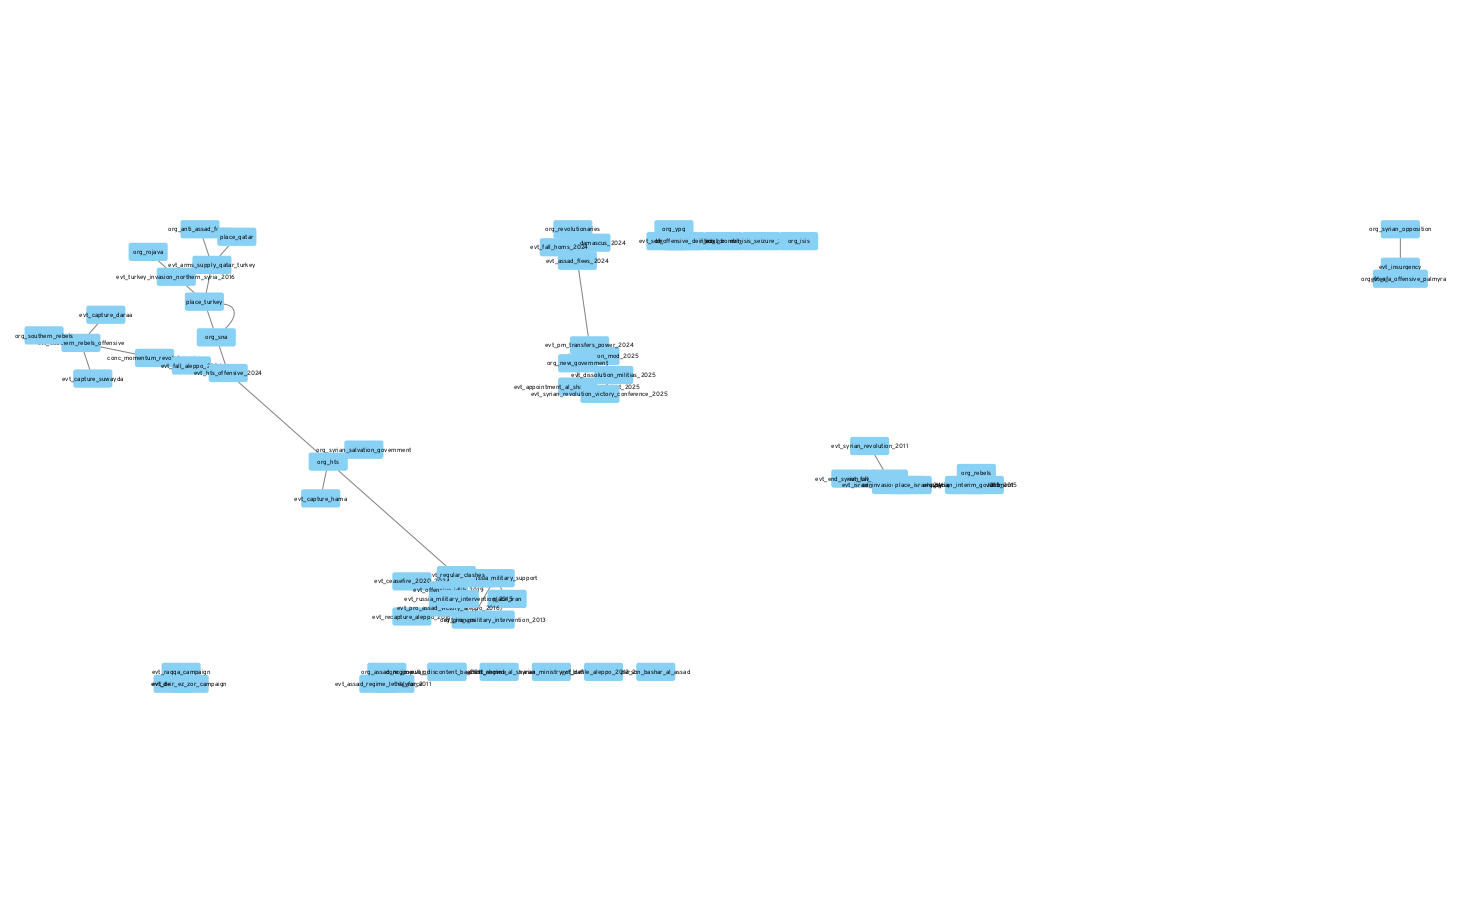

In [6]:
layouts.get_layout_names()
layouts.layout_network(layout_name="circular")
notebook_export_show_image()



## Results
Overall, not a terrible first try. Improvements have to be made to the prompt so that it fits the Pydantic parser model we set up earlier, but a lot of the connections do make sense with further analyzing.
Some next steps include multiple Wikipedia articles and seeing the connections, chunking the text for more potential accuracy, and setting up Voila for an interactive web app with Cytoscape.js.
